## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Prepare for viewing long text in CSVs

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the two data files

In [4]:
subtweets_data = json.load(open("../data/other_data/subtweets.json"))

In [5]:
non_subtweets_data = json.load(open("../data/other_data/non_subtweets.json"))

#### Find the length of the smaller dataset

In [6]:
largest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Check the lengths and see examples
#### Cut down both datasets to be the same size

In [7]:
subtweets_data = [t["tweet_data"]["full_text"] for t in subtweets_data][:largest_length]

In [8]:
print("Subtweets dataset length: {}".format(len(subtweets_data)))

Subtweets dataset length: 4257


In [9]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
I personally don't find it difficult to leave out personal attacks from policy debates. I thought this was part of being an adult.


In [10]:
non_subtweets_data = [t["tweet_data"]["full_text"] for t in non_subtweets_data][:largest_length]

In [11]:
print("Non-subtweets dataset length: {}".format(len(non_subtweets_data)))

Non-subtweets dataset length: 4257


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
i done flashed my titty multiple times today


#### Prepare data for training

In [13]:
subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "subtweet") for tweet in subtweets_data]

In [14]:
non_subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [15]:
training_data = subtweets_data + non_subtweets_data

#### Create training and test sets from the single training set I made before

In [16]:
text_train, text_test, class_train, class_test = train_test_split([row[0] for row in training_data], 
                                                                  [row[1] for row in training_data], test_size=0.1)

#### Use NLTK's tokenizer instead of Scikit's

In [17]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [18]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            
            
            weighted_dict = {"num_subtweet": num_subtweet,
                             "num_at_symbols": num_at_symbols, 
                             "num_urls": num_urls,
                             "num_others": num_others,
                             "num_selfs": num_selfs}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [19]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [20]:
text_training_data = np.array([row[0] for row in training_data])

In [21]:
class_training_data = np.array([row[1] for row in training_data])

In [22]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [23]:
cnf_matrix = np.zeros((2, 2), dtype=int)
for train_index, test_index in kf.split(text_training_data):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
    
    # print(predictions)
    
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

non-subtweet       0.73      0.63      0.68       402
    subtweet       0.71      0.79      0.75       450

 avg / total       0.72      0.72      0.71       852

              precision    recall  f1-score   support

non-subtweet       0.76      0.61      0.68       446
    subtweet       0.65      0.79      0.71       406

 avg / total       0.71      0.69      0.69       852

              precision    recall  f1-score   support

non-subtweet       0.74      0.60      0.66       433
    subtweet       0.65      0.78      0.71       419

 avg / total       0.70      0.69      0.69       852

              precision    recall  f1-score   support

non-subtweet       0.73      0.60      0.66       429
    subtweet       0.66      0.77      0.71       423

 avg / total       0.69      0.69      0.69       852

              precision    recall  f1-score   support

non-subtweet       0.75      0.61      0.67       439
    subtweet   

#### Define function for visualizing confusion matrices

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

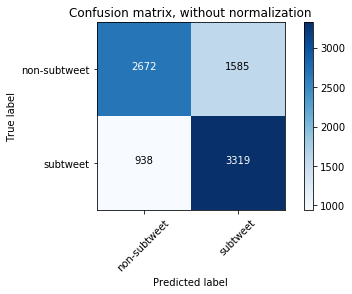

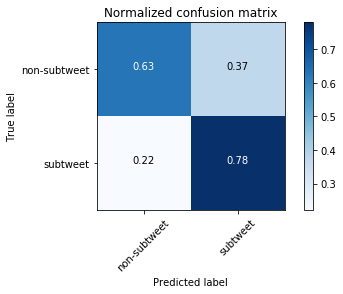

In [25]:
class_names = ["non-subtweet", "subtweet"]

# cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [26]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [27]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [28]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [29]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [30]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1,None,0.098216,0.901784,Isn't it funny how some people don't know their place?
2,None,0.119496,0.880504,How come you people act like this?
0,None,0.132949,0.867051,Some people don't know their place.
3,None,0.178224,0.821776,You're such a nerd.
4,None,0.270808,0.729192,"I love Noah, he's so cool."


#### Test on actual tweets

In [31]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [32]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [33]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [34]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [35]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### Use randomly selected 5K rows from dataset

In [36]:
naji_df = naji_df.sample(n=5000).reset_index(drop=True)

#### Print and time the tests

In [37]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 931 ms, sys: 20.9 ms, total: 952 ms
Wall time: 957 ms


In [38]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

#### Plot the results

In [39]:
naji_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [40]:
naji_df_for_plotting = naji_df.drop(naji_df_columns, axis=1).head(10)

In [41]:
naji_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2670,1,0.064980,0.935020,"""Yeah I know. You're always eating when I see you."" Bomb quote about me"
4703,0,0.080752,0.919248,I hear everyone talk about how great twitter is and how you can follow so many cool things. I just don't know how
4767,1,0.090387,0.909613,"When u really love sum1,it means willing to let them go and if they come back,thats true love"
1411,0,0.108403,0.891597,Dear boyfriend: please feel better soon. I don't like it when you're sick & I can't do a whole lot to help.
4824,0,0.113317,0.886683,i might not walk and go to the dance. if you dont have all your books turn in you cant :'(
4758,0,0.120012,0.879988,he doesnt answer when we call. i think he's mad at me
4273,0,0.121394,0.878606,It's cool that I'm over 100 followers now... but it sucks that a lot of them are spammers...
989,0,0.122963,0.877037,"The one thing I hate about summer is bees. You can hear them flying around you but when you look, can't see them anywhere. Ugh."
3267,1,0.128024,0.871976,"OK, my last tweets sounded like I'm drunk all day, don't sleep that much and hate my work... I should stop tweeting"
25,1,0.129554,0.870446,"I look at how many characters you can write in a twitter twit It turns out there are 140. Nice, cool and awesone. Still 22 to go. ok 5. 1"


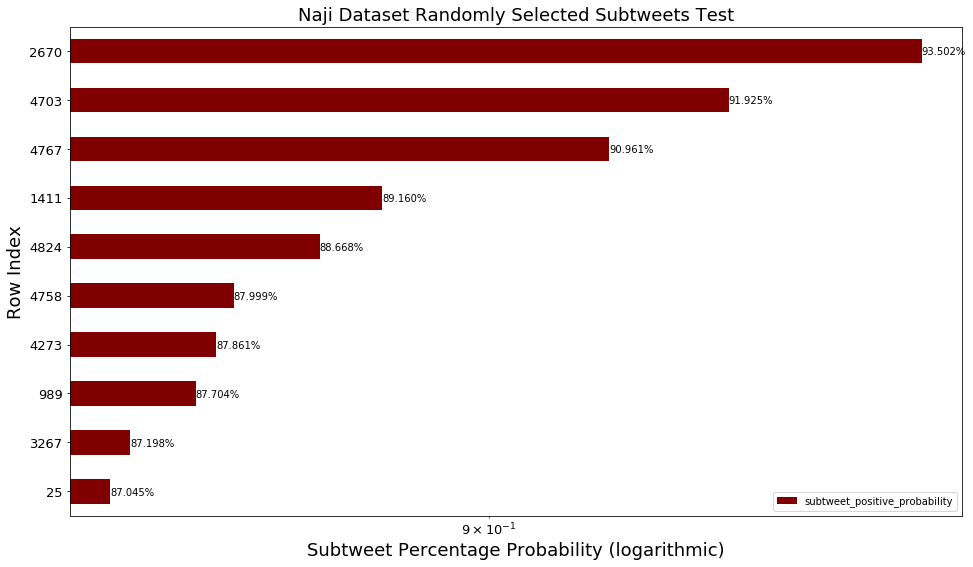

In [42]:
ax = naji_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Naji Dataset Randomly Selected Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Tests on friends' tweets

#### Aaron

In [43]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [44]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 640 ms, sys: 9.5 ms, total: 649 ms
Wall time: 652 ms


In [45]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [46]:
aaron_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [47]:
aaron_df_for_plotting = aaron_df.drop(aaron_df_columns, axis=1).head(10)

In [48]:
aaron_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1600,None,0.049079,0.950921,"shoutout to all the people tweeting #BeforeTheInternetExisted saying ""we actually talked to people face to face"" bc u know they're guilty"
2893,None,0.052282,0.947718,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
821,None,0.052693,0.947307,tfw you're proud of something and want to share it with others but you realize that nobody actually cares
3318,None,0.059191,0.940809,"If you don't follow me on Instagram, you're missing outpic.twitter.com/B2U8aJvSY3"
2978,None,0.060181,0.939819,"You know, I really enjoy Howard Stern's comedy on his radio show, but you really put me off from listening when you constantly bash (1/2)"
385,None,0.060629,0.939371,My dog literally changed positions on my bed just so she could watch me eat at my desk but pretends she asleep when I look at her like I can't tell when she huffs and puffs because she's not getting any
2445,None,0.062287,0.937713,If you don't have tweet notifications turned on for me are we really friends
3559,None,0.067310,0.932690,"Hey, it's really annoying when all you talk about is your bad childhood. Shut up."
1994,None,0.068930,0.931070,i can't believe noah just trolls twitter waiting for you to tweet so he can respond without you tagging him
3221,None,0.069416,0.930584,I still don't understand why my brother feels a need to literally narrate his life on Twitter. Nobody cares when you go to sleep or wake up


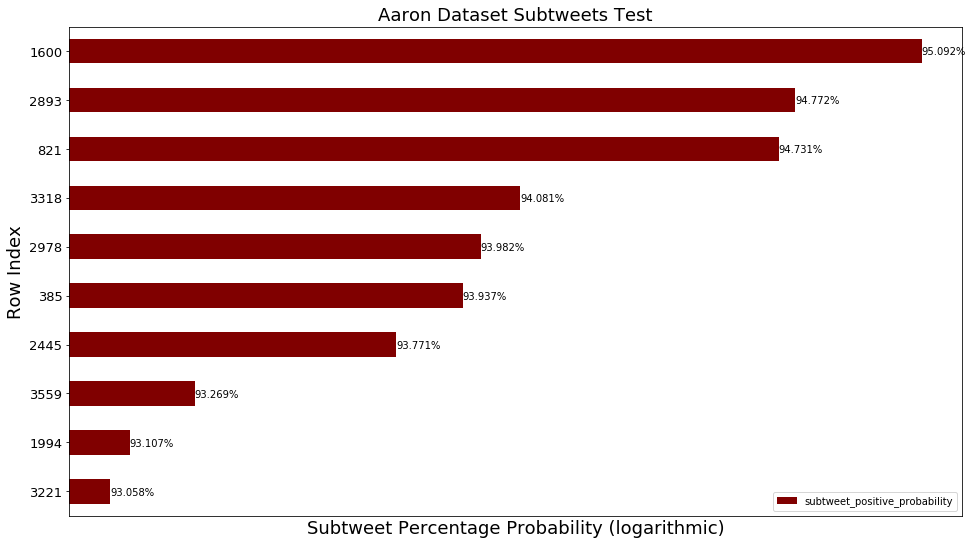

In [49]:
ax = aaron_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Aaron Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Julia

In [50]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [51]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.56 s, sys: 27.5 ms, total: 1.59 s
Wall time: 1.65 s


In [52]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [53]:
julia_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [54]:
julia_df_for_plotting = julia_df.drop(julia_df_columns, axis=1).head(10)

In [55]:
julia_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2926,None,0.033656,0.966344,"if ur white and u didn't grow up saying ""y'all"" but you do now bc #trendy, consider NOT doing that"
4395,None,0.035063,0.964937,"if you continually cross post content on various social media to get validation that you're funny, you, regrettably, are probably not funny"
4629,None,0.044929,0.955071,how do you tell ur coach who probably hates ur forgetful ass at this point that you can't go to practice bc u stayed up all night lmk
4197,None,0.046616,0.953384,u kno the feel where u rly want to tweet about a part of ur life to get feelings out but u can't bc it could be regarded as a subtweet?? ya
6569,None,0.048303,0.951697,tfw really wanting to get out of class to work on ur essay but once ur back in ur dorm u want to do ANYTHING BUT WRITE THIS ESSAY
663,None,0.048613,0.951387,even if you are committed to cheating how can you possibly think that p/c are on the same level as v/m when you're watching papadakis shakily clamber onto cizeron for a lift in their short dance after you've just seen tessa hook her legs around scott's head and spin in THEIR ...
3453,None,0.050001,0.949999,"when babies laugh they use their entire bodies bc they're unselfconscious and are thus pictures of perfect, unbridled joy"
4071,None,0.050310,0.949690,"if u rly need motivation, call it an incentive of honesty: people don't think ur going to cheat them all the fucking time. amazing!"
6086,None,0.051545,0.948455,tfw ur anxiety kills ur appetite but you can't do anything done bc ur still hungry so u just get more anxiety #gr8
6266,None,0.052594,0.947406,when ur boss pulls you aside to tell you about how impressed they are w ur diligence in ur first week of workpic.twitter.com/puHjlzZIu7


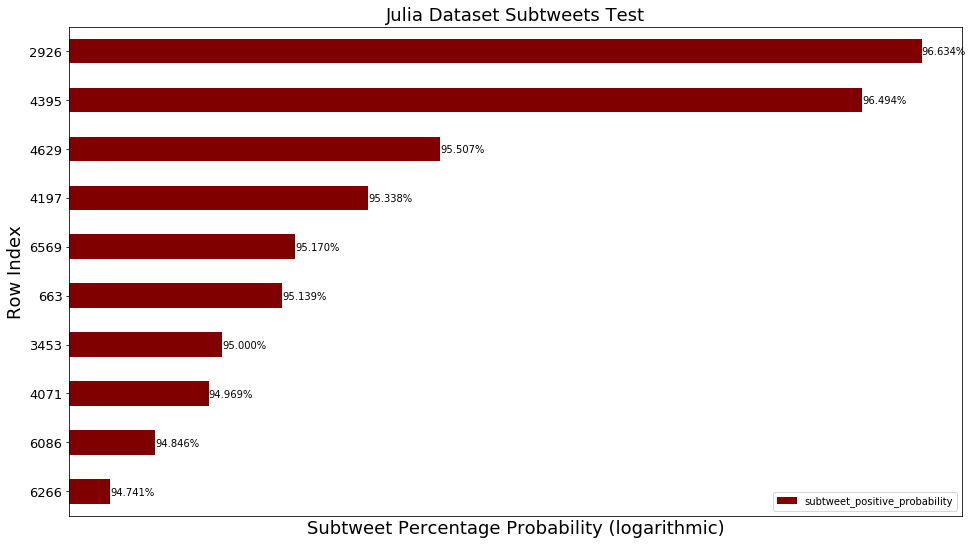

In [56]:
ax = julia_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Julia Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Zoe

In [57]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [58]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 293 ms, sys: 15 ms, total: 308 ms
Wall time: 434 ms


In [59]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [60]:
zoe_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [61]:
zoe_df_for_plotting = zoe_df.drop(zoe_df_columns, axis=1).head(10)

In [62]:
zoe_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
583,None,0.042699,0.957301,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
303,None,0.053219,0.946781,they say pets can sense when ur Not Okay™ and I think it's true bc pinwheel refuses to fall asleep anywhere but on my lap/chest
456,None,0.055422,0.944578,when ur heart rate is fast before bed and u can't tell if it's the anxiety heart rate or the insomnia heart rate BUT you realize you're not anxious so it's probably the insomnia \n\nwelcome back old friend you have not been missed
1115,None,0.056340,0.943660,if u don't watch all ur snap friends stories ur probably 2 self-involved
788,None,0.058704,0.941296,u ever read a tweet and ur like damn did u write that just to upset me??? Well it only worked for three seconds
848,None,0.069304,0.930696,that one buzzfeed employee who thinks they're really funny but they aren't
277,None,0.073497,0.926503,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them in their lamentations?? I Don't Like This
216,None,0.074794,0.925206,did you say no and you're mad i would dare suggest such a change or are you mad someone said no
208,None,0.075451,0.924549,u posted this tweet moments after i got 2 insta notifications for live videos and i'm choosing to assume that you got the same notifications
791,None,0.075947,0.924053,Delet this tweet \nWhen ur famous u don't need people seeing this


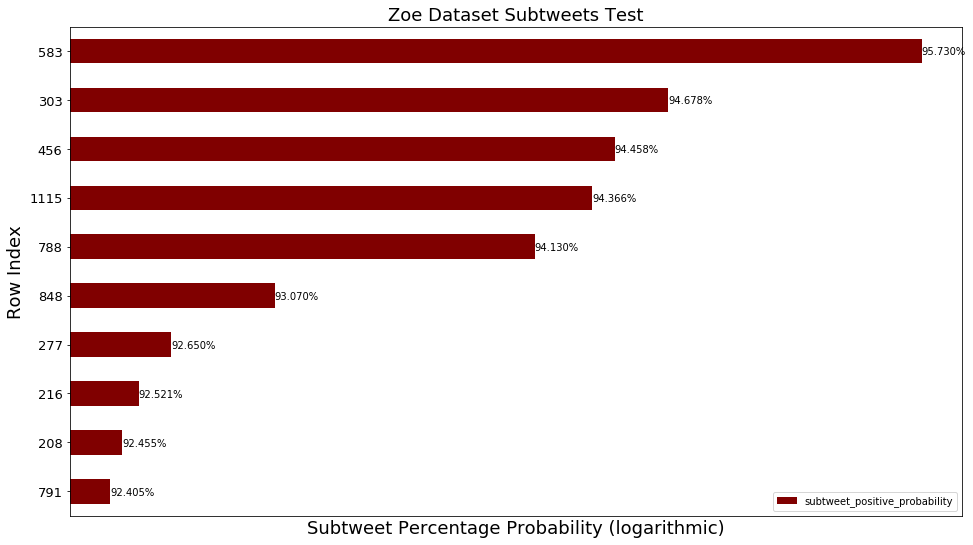

In [63]:
ax = zoe_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Zoe Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Noah

In [64]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [65]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.23 s, sys: 49.8 ms, total: 1.28 s
Wall time: 1.66 s


In [66]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [67]:
noah_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [68]:
noah_df_for_plotting = noah_df.drop(noah_df_columns, axis=1).head(10)

In [69]:
noah_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
4166,None,0.031584,0.968416,TFW your old boss walks into DTR and you feel like you're supposed to look like you're working even though you don't work for her
2891,None,0.032784,0.967216,When you're telling me to die or making me feel inferior I don't like you but you're normally very kind so I'm content with that
3236,None,0.039391,0.960609,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
4192,None,0.040156,0.959844,You ever wonder how your siblings are when you're not with them? haha me neither
696,None,0.043889,0.956111,"I FIGURED OUT THAT I DON'T REALLY KNOW\nIt's not satirizing anything in particular, and he's completely genuine across all his comedy pieces. I've described it before as ""broken comedy"" because it's not quite entirely nonsensical but it's really clearly funny because it's bad."
3525,None,0.047873,0.952127,some people want their kids to take care of them when they are elderly but I plan to enslave sentient AI to do that for me until the end.
3173,None,0.049315,0.950685,"if you can't tell if it's enough words, the useless block quotes have probably fulfilled their purpose lmao"
4115,None,0.050836,0.949164,Tbh if you're a confident person I both envy you and can't wait for you to realize that all your efforts will ultimately fade into the void
3249,None,0.056395,0.943605,IF U CALL URSELF A WEEB BUT DONT HAVE ANIME PROF PICS ON ALL SOCIAL MEDIA\n DELETE UR ACCOUNTS
992,None,0.058168,0.941832,wow the bots really likes this tweet\nBUT YOU DONT KNOW\nWHAT THEY WENT THROUGH\nFOR HER TO OPEN UP\nAND *NOT* BE A SOCIOPATHIC MURDERER\nand I think it was only 2-3 times


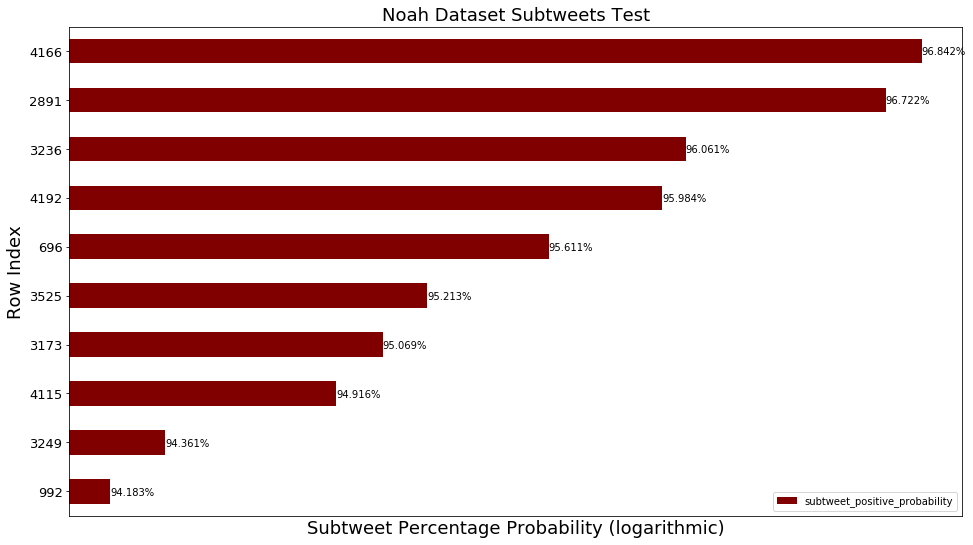

In [70]:
ax = noah_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Noah Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Test it in realtime
#### Define some useful variables for later

In [71]:
THRESHOLD = 0.95 # 95% positives and higher, only
DURATION = 60 # 1 minute

#### Load Twitter API credentials

In [72]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Use the API credentials to connect to the API

In [73]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=1, timeout=120, # 2 minutes
                 compression=True, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Prepare the final dataframe

In [74]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [75]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        choices = ["retweet", "like", "retweet and like", "reply"]
        
        id_str = status.id_str
        screen_name = status.user.screen_name
        created_at = status.created_at
        retweeted = status.retweeted
        in_reply_to = status.in_reply_to_status_id
        
        text = status.text.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<")
        
        # negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability}
        
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD, 
                not retweeted,
                "RT @" not in text, 
                not in_reply_to]):
            
            decision = choice(choices)
            if decision == "retweet":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
            
            if decision == "like":
                api.create_favorite(id_str)
            
            if decision == "retweet and like":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
                api.create_favorite(id_str)
            
            if decision == "reply":
                api.update_status("@{} Is this a subtweet? {:.3%}".format(screen_name, positive_probability), id_str)
            
            subtweets_live_list.append(row)
            subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                         ascending=False)
            
            subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv")
            
            print(("Subtweet from @{0} (Probability of {1:.3%}):\n" + 
                   "Time: {2}\n" + 
                   "Tweet: {3}\n" +
                   "Total tweets acquired: {4}\n").format(print_list[0], 
                                                          print_list[1], 
                                                          print_list[2],
                                                          print_list[3],
                                                          (len(subtweets_live_list) 
                                                           + len(non_subtweets_live_list))))
            
            return row
        else:
            non_subtweets_live_list.append(row)
            non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                                 ascending=False)
            non_subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/non_subtweets_live_data.csv")
            
            return row

#### Get a list of the IDs of all my mutuals and my mutuals' followers

In [76]:
def get_mutuals():
    my_followers = [str(user_id) for ids_list in 
                    tweepy.Cursor(api.followers_ids, 
                                  screen_name="NoahSegalGould").pages() 
                    for user_id in ids_list]
    my_followeds = [str(user_id) for ids_list in 
                   tweepy.Cursor(api.friends_ids, 
                                 screen_name="NoahSegalGould").pages() 
                   for user_id in ids_list]
    
    my_mutuals = list(set(my_followers) & set(my_followeds))
    
    bots = ["890031065057853440", "895685688582180864", 
            "894658603977777152", "970553455709446144", 
            "786489395519983617", "975981192817373184"]
    
    my_mutuals = [m for m in my_mutuals if m not in bots]
    
    with open("../data/other_data/NoahSegalGould_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals, outfile)
    
    return my_mutuals

In [77]:
def get_mutuals_and_mutuals_mutuals_ids(mutuals_threshold=250):
    my_mutuals = get_mutuals()
    my_mutuals_mutuals = my_mutuals[:]

    for i, mutual in enumerate(my_mutuals):
        start_time = time()
        user = api.get_user(user_id=mutual)
        name = user.screen_name
        is_protected = user.protected
        if not is_protected:
            mutuals_followers = []
            followers_cursor = tweepy.Cursor(api.followers_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_follower = followers_cursor.next()
                    mutuals_followers.append(str(mutuals_follower))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_followeds = []
            followeds_cursor = tweepy.Cursor(api.friends_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_followed = followeds_cursor.next()
                    mutuals_followeds.append(str(mutuals_followed))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_mutuals = list(set(mutuals_followers) & set(mutuals_followeds))
            print("{} mutuals for mutual {}: {}".format(len(mutuals_mutuals), i+1, name))
            if len(mutuals_mutuals) <= mutuals_threshold: # Ignore my mutuals if they have a lot of mutuals
                my_mutuals_mutuals.extend(mutuals_mutuals)
            else:
                print("\tSkipping: {}".format(name))
        else:
            continue
        end_time = time()
        with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
            json.dump(my_mutuals_mutuals, outfile)
        print("{0:.2f} seconds for getting the mutuals' IDs of mutual {1}: {2}\n".format((end_time - start_time), 
                                                                                         i+1, name))
    my_mutuals_mutuals = [str(mu) for mu in sorted([int(m) for m in list(set(my_mutuals_mutuals))])]
    with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals_mutuals, outfile, indent=4)
    return my_mutuals_mutuals

In [78]:
# %%time
# my_mutuals_mutuals = get_mutuals_and_mutuals_mutuals_ids()

In [79]:
# %%time
# my_mutuals = get_mutuals()

In [80]:
# my_mutuals_mutuals = json.load(open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json"))

In [81]:
# print("Total number of my mutuals: {}".format(len(my_mutuals)))

In [82]:
# print("Total number of my mutuals and my mutuals' mutuals: {}".format(len(my_mutuals_mutuals)))

#### Instantiate the listener

In [83]:
# stream_listener = StreamListener()
# stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [84]:
# %%time
# stream.filter(locations=[-73.920176, 42.009637, -73.899739, 42.033421], stall_warnings=True, languages=["en"], async=True)
# stream.filter(follow=my_mutuals_mutuals, stall_warnings=True, languages=["en"], async=True)
# print("Streaming has started.")
# sleep(DURATION)
# stream.disconnect()

#### Plot the results

In [85]:
# subtweets_df = pd.read_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv", index_col=0)

In [86]:
# subtweets_df_columns = ["screen_name", "time", "tweet"]

In [87]:
# subtweets_df_for_plotting = subtweets_df.drop(subtweets_df_columns, axis=1).head(10)

In [88]:
# subtweets_df.head(10)

In [89]:
# ax = subtweets_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
# ax.set_alpha(0.8)
# ax.set_title("Live Downloaded Subtweets Test", fontsize=18)
# ax.set_ylabel("Row Index", fontsize=18);
# ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
# for i in ax.patches:
#     ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
# ax.invert_yaxis()